In [1]:
import numpy as np
import pandas as pd
import scipy.stats as ss
from datetime import datetime

import seaborn as sns
import plotly.express as px
import matplotlib.pyplot as plt
import pingouin as pg

from scipy.stats import chi2_contingency, chi2, mannwhitneyu, shapiro, kruskal, norm
import statsmodels.api as sa 

import warnings
warnings.filterwarnings("ignore")

sns.set(rc={'figure.figsize':(10,6)}, style="whitegrid")

# 1. Загрузка данных и предварительный анализ

## 1.1. Информация о пользователях  

In [2]:
df_users_test = pd.read_csv('Проект_3_users_test.csv', sep=';')

df_users_control_1 = pd.read_csv('Проект_3_users_control_1.csv', sep=';')

df_users_control_2 = pd.read_csv('Проект_3_users_control_2.csv', sep=';')


Объединим три датафрейма в один, но сначала в каждом датафрейме создадим столбец group (группа), чтобы определять принадлежность пользователей к группам. Пользователи в тестовой группе будут относится к группе test, пользователи контрольных групп будут относится к control_1 и control_2 соответственно.

In [3]:
# создание нового столбца group

df_users_test['group'] = 'test'

df_users_control_1['group'] = 'control_1'

df_users_control_2['group'] = 'control_2'

df_users = pd.concat([df_users_test, df_users_control_1, df_users_control_2])


In [4]:
#проверим правильно ли объединили датафреймы

print('Размерность датафрейма контрольной группы 1: ' , df_users_control_1.shape)

print('Размерность датафрейма контрольной группы 2: ' , df_users_control_2.shape)

print('Размерность тестового датафрейма: ' , df_users_test.shape)

df_users.groupby('group', as_index=False)['uid'].size()


Размерность датафрейма контрольной группы 1:  (4340, 14)
Размерность датафрейма контрольной группы 2:  (4264, 14)
Размерность тестового датафрейма:  (4308, 14)


,group,size
0,control_1,4340
1,control_2,4264
2,test,4308


In [5]:
# поиск количества дублирующих строк в датафрейме users

print('Количество дублирующих строк: ' , df_users.duplicated().sum())


Количество дублирующих строк:  0


In [6]:
# поиск количества пропусков в датафрейме users

print('Количество пропусков: \n', df_users.isna().sum())


Количество пропусков: 
 uid                     0
age                     0
attraction_coeff        0
coins               12742
country                 0
visit_days           4018
gender                  0
age_filter_start        0
age_filter_end          0
views_count             0
was_premium         11657
is_premium          12372
total_revenue           0
group                   0
dtype: int64


In [7]:
# посмотрим уникальные значения в столбце is_premium и was_premium

print('Уникальные значения в столбце is_premium', df_users.is_premium.unique())

print('Уникальные значения в столбце was_premium', df_users.was_premium.unique())


Уникальные значения в столбце is_premium [nan  1.]
Уникальные значения в столбце was_premium [nan  1.]


В объединенном датафрейме users пропуски имеются в четырех столбцах: coins (монеты), visit_days (указаны дни посещения приложения после регистрации), is_premium (является ли премиум), was_premium (был ли когда премиум).

Что касается пропусков в столбцах is_premium и was_premium, то в них всего два значени 0 или 1, поэтому вместо 0 стоит значение nan, думаю, что логично поменять на 0 и изменить тип данных на int.

В столбцах coins и visit_days пользователь скорее всего не использовал приложение и нет монет, поэтому nan заменим на 0. 

In [8]:
# замена пропусков на ноль

df_users = df_users.fillna(0)

df_users['is_premium'] = df_users['is_premium'].astype(np.int64)

df_users['was_premium'] = df_users['was_premium'].astype(np.int64)


## 1.2. Информация о платежах пользователей

In [9]:
df_trans_test = pd.read_csv('Проект_3_transactions_test.csv', sep=';', parse_dates = ['joined_at','paid_at'])

df_trans_control_1 = pd.read_csv('Проект_3_transactions_control_1.csv', sep=';', parse_dates = ['joined_at','paid_at'])

df_trans_control_2 = pd.read_csv('Проект_3_transactions_control_2.csv', sep=';', parse_dates = ['joined_at','paid_at'])


In [10]:
# соединим три датафрейма в один, но до этого добавим столбец group

df_trans_test['group'] = 'test'

df_trans_control_1['group'] = 'control_1'

df_trans_control_2['group'] = 'control_2'

df_trans = pd.concat([df_trans_test, df_trans_control_1, df_trans_control_2])


In [11]:
#проверим правильно ли объединили датафреймы

print('Размерность датафрейма контрольной группы 1: ' , df_trans_control_1.shape)

print('Размерность датафрейма контрольной группы 2: ' , df_trans_control_2.shape)

print('Размерность тестового датафрейма: ' , df_trans_test.shape)

df_trans.groupby('group', as_index=False)['uid'].size()


Размерность датафрейма контрольной группы 1:  (1007, 9)
Размерность датафрейма контрольной группы 2:  (328, 9)
Размерность тестового датафрейма:  (273, 9)


,group,size
0,control_1,1007
1,control_2,328
2,test,273


In [12]:
# поиск количества пропусков в датафрейме trans

print('Количество пропусков: \n', df_trans.isna().sum())


Количество пропусков: 
 uid             630
country         630
joined_at       630
paid_at         630
revenue         630
payment_id      630
from_page       630
product_type    630
group             0
dtype: int64


In [13]:
# посмотрим сами пропуски

df_trans.loc[df_trans.isnull().any(axis=1)]


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
377,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,control_1
378,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,control_1
379,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,control_1
380,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,control_1
381,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,control_1
...,...,...,...,...,...,...,...,...,...
1002,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,control_1
1003,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,control_1
1004,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,control_1
1005,NaN,NaN,NaT,NaT,NaN,NaN,NaN,NaN,control_1


In [14]:
# удалим пропуски

df_trans = df_trans.dropna()


In [15]:
# найдем дублирующие строки в датафрейме

df_trans.duplicated().sum()


33

In [16]:
# посмотрим дублирующие строки и отсортируем по uid

duplicates = df_trans.duplicated(subset=df_trans.columns, keep=False)

duplicate_rows = df_trans[duplicates].sort_values('uid')

duplicate_rows 


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
344,891252072.0,Argentina,2017-06-11 19:56:00,2017-08-11 18:18:00,1261.0,19.0,empty_likes,coins,control_1
341,891252072.0,Argentina,2017-06-11 19:56:00,2017-08-11 18:18:00,1261.0,19.0,empty_likes,coins,control_1
301,891320916.0,Israel,2017-05-11 19:36:00,2017-07-11 20:04:00,3783.0,67.0,empty_likes,other_type,control_1
227,891320916.0,Israel,2017-05-11 19:36:00,2017-07-11 20:04:00,3783.0,67.0,empty_likes,other_type,control_1
22,891365490.0,United States of America,2017-05-11 03:55:00,2017-06-11 00:28:00,1261.0,19.0,empty_likes,coins,control_1
...,...,...,...,...,...,...,...,...,...
149,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 02:08:00,1261.0,19.0,gifts,coins,control_1
304,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 02:26:00,31525.0,19.0,menu,coins,control_1
297,892333905.0,Italy,2017-10-16 01:38:00,2017-10-16 02:26:00,31525.0,19.0,menu,coins,control_1
243,892339626.0,United States of America,2017-10-15 23:21:00,2017-10-20 18:14:00,754.0,19.0,empty_likes,coins,test


In [17]:
# удалим дублирующие строки

df_trans = df_trans.drop_duplicates().reset_index(drop=True)


# 2. Анализ репрезентативности групп АВ - теста

Проанализируем распредление в группах:

1. По странам.

2. По гендерному признаку.

3. По возрастному признаку.

4. Соответсивие одному временному периоду.

5. Разница между датой регистрации и датой транзакции.

6. Идентификатор платежа.


## 2.1. Информация о пользователях  

Выполним проверку системы сплитования чтобы убедиться, что пользователи правильно разделены на группы и, что тестирование проводится корректно. Для этого проверим пересечение пользователей между группами.

In [18]:
# создадим множества данных юзеров и применим метод пересечения множеств

gr_test = set(df_users.query("group == 'test'").uid)
gr_control_1 = set(df_users.query("group == 'control_1'").uid)
gr_control_2 = set(df_users.query("group == 'control_2'").uid) 

gr_test.intersection(gr_control_1)


set()

In [19]:
gr_test.intersection(gr_control_2)

set()

In [20]:
gr_control_1.intersection(gr_control_2)

set()

### 2.1.1. Распределение по странам

In [21]:
df_users.country.nunique()

72

In [22]:
# найдем уникальные значения групп для каждой страны

groups_in_countries = pd.DataFrame(df_users.groupby('country')['group'].unique()).reset_index().sort_values('country')

groups_in_countries['group_count'] = groups_in_countries['group'].apply(len)


# найдем те страны где групп меньше трех

groups_in_countries_min = groups_in_countries.query('group_count < 3')

groups_in_countries_min.shape


(47, 3)

In [23]:
# создадим переменную с списком тех стран где групп меньше трех

country_list = groups_in_countries_min['country'].tolist()


In [24]:
# посчитаем сколько пользователей относится к тем странам где представлено групп меньше трех

selected_df = df_users[df_users['country'].isin(country_list)]

selected_df_uid_count = selected_df.groupby('country', as_index=False)['uid'].count()

selected_df_uid_count['uid'].sum()


84

In [25]:
# удалим страны из датафрейма с группами меньше трех
# всего получилось 47 страны и 84 пользователя

df_users = df_users[~df_users['country'].isin(country_list)].reset_index(drop=True)


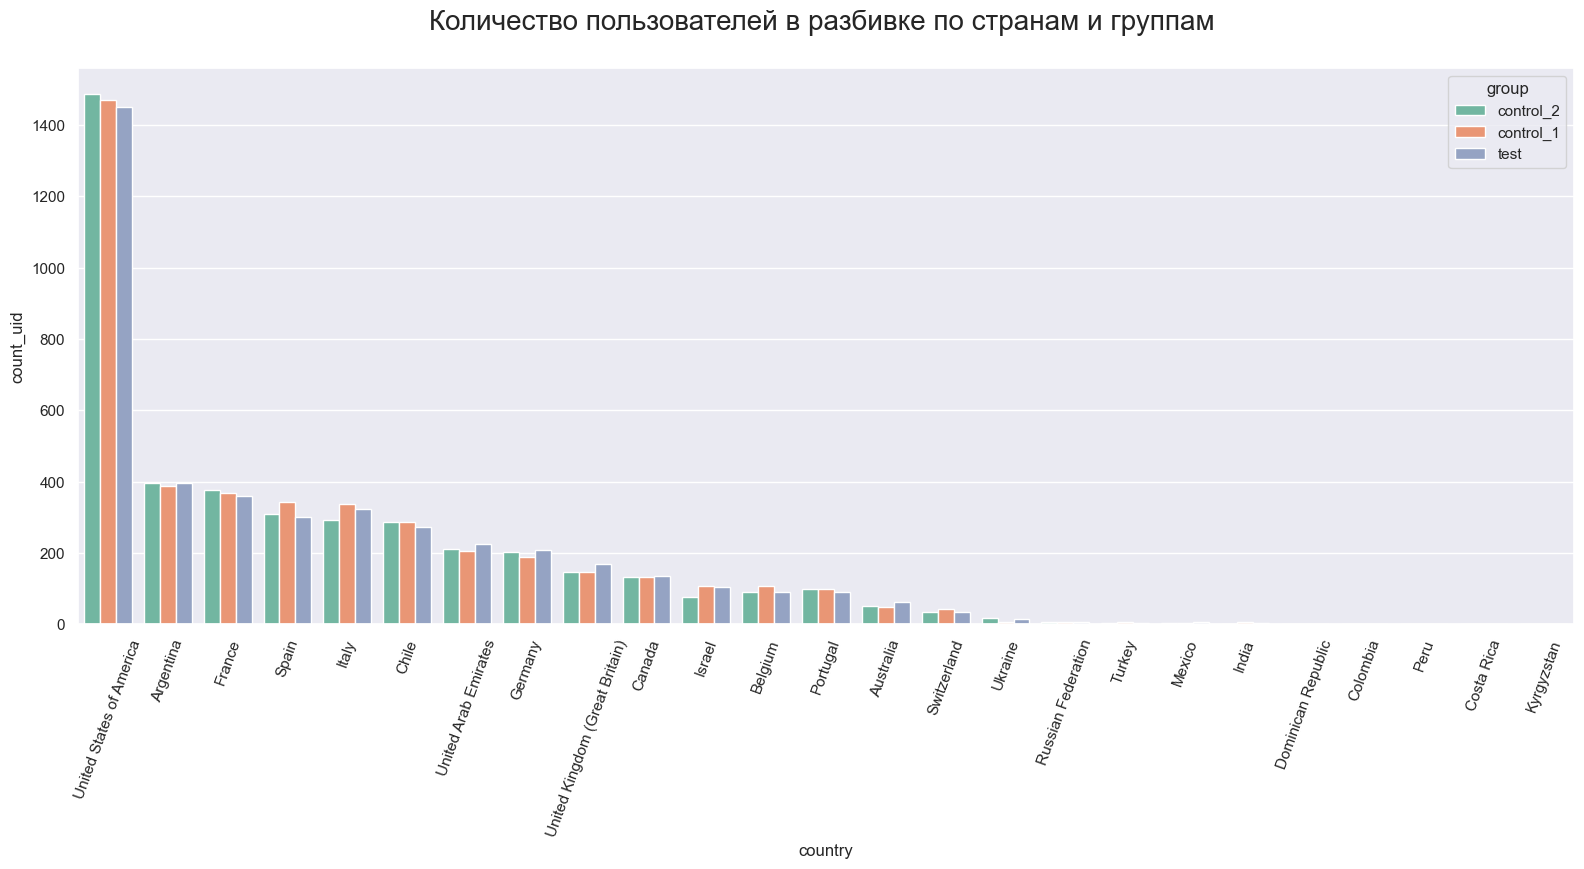

In [26]:
# построим график распределения пользователей по странам и группам

sns.set(rc={'figure.figsize':(16,8.27)})

sns.barplot(data=df_users.groupby(['group', 'country'], as_index=False).agg(count_uid = ("uid", 'count')).sort_values('count_uid', ascending=False),
            x='country', y='count_uid', palette='Set2', hue='group')

plt.xticks(rotation=70)

plt.tight_layout()

plt.title('Количество пользователей в разбивке по странам и группам \n', fontsize=20)

plt.show()


### 2.1.2. Распределение по гендерному признаку

In [27]:
# подсчитаем количество уникальных пользователей для каждой комбинации группы и пола

gender_count = df_users.groupby(['group','gender'], as_index=False).agg({'uid': 'count'})


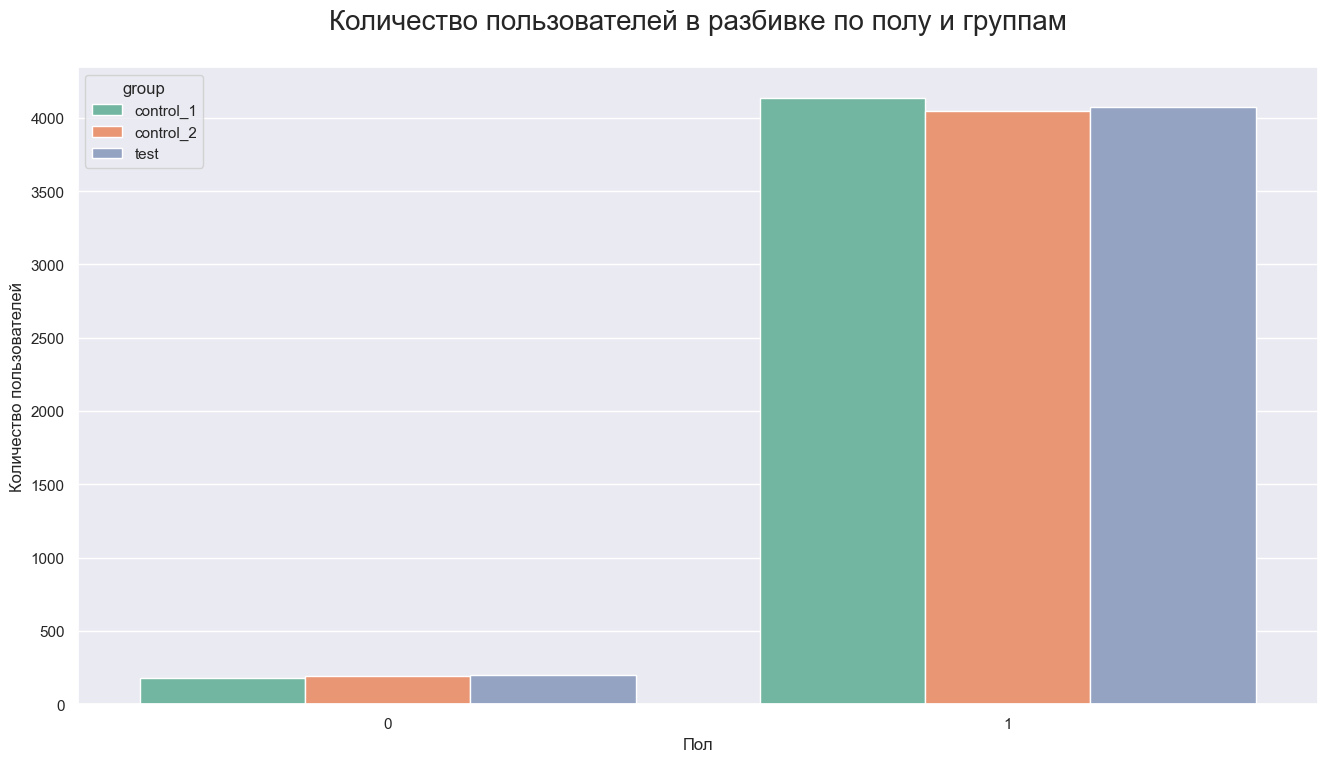

In [28]:
# построим график количества пользователей по полу и группам

sns.set(rc={'figure.figsize':(16,8.27)})

sns.barplot(data=gender_count, x='gender', y='uid', palette='Set2', hue='group')

plt.xlabel('Пол')

plt.ylabel('Количество пользователей')

plt.title('Количество пользователей в разбивке по полу и группам\n', fontsize=20)

plt.show()


### 2.1.3. Распределение по возрасту

In [29]:
# найдем информацию о количестве пользователей для каждой комбинации группы и возраста

u_age = df_users.groupby(['group','age'], as_index=False).size().sort_values('age')


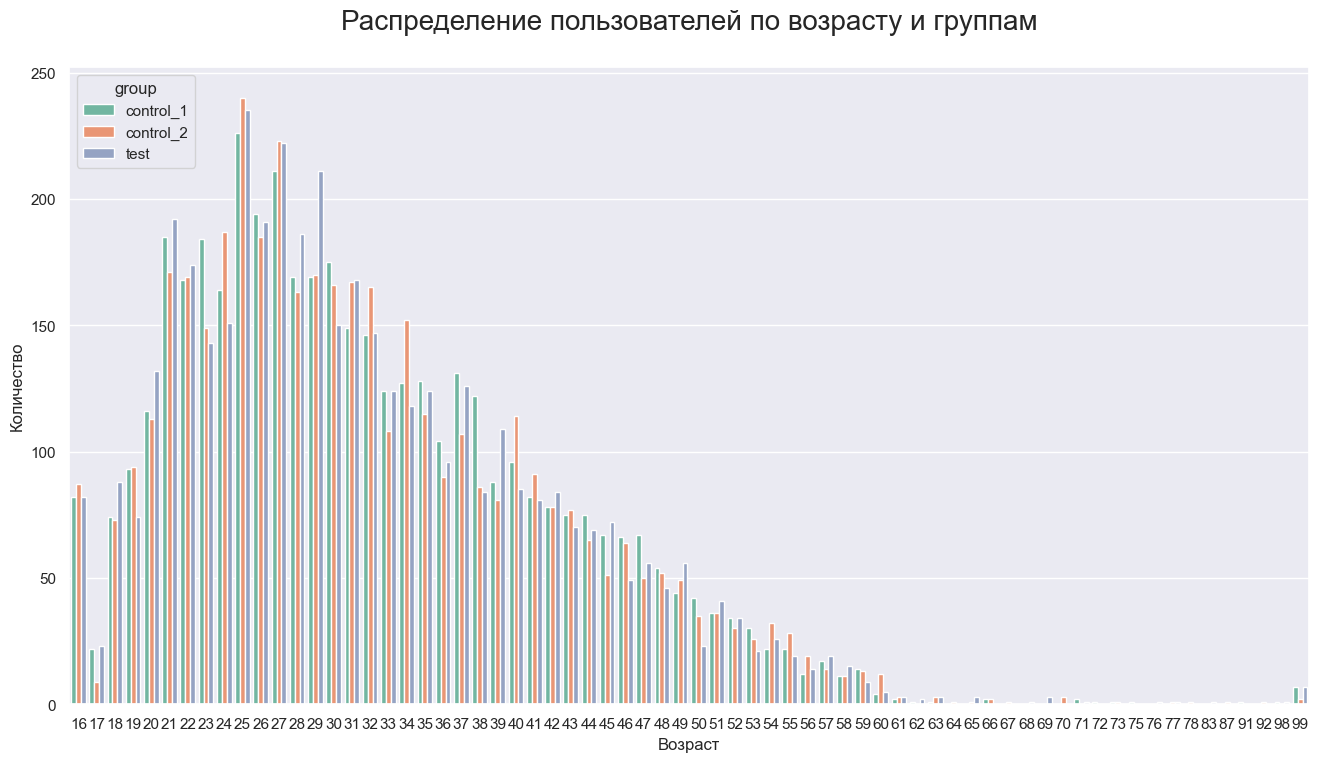

In [30]:
# построим график о количестве пользователей для каждой комбинации группы и возраста

sns.set(rc={'figure.figsize':(16,8.27)})

sns.barplot(data=u_age, x='age', y='size', hue='group', palette='Set2')

plt.xlabel('Возраст')

plt.ylabel('Количество')

plt.title('Распределение пользователей по возрасту и группам\n', fontsize=20)

plt.show()


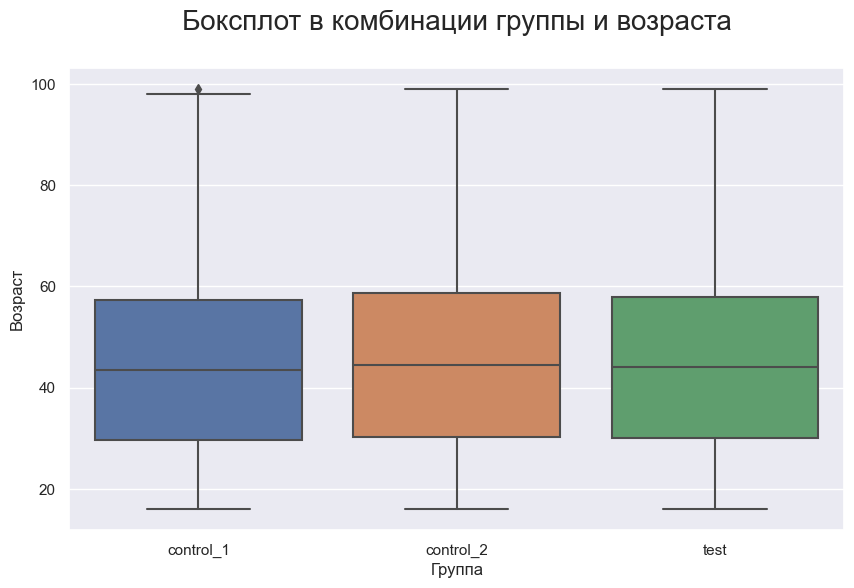

In [31]:
# построение боксплотов для каждой комбинации группы и возраста

plt.figure(figsize=(10, 6))

sns.boxplot(x='group', y='age', data=u_age)

plt.xlabel('Группа')

plt.ylabel('Возраст')

plt.title('Боксплот в комбинации группы и возраста\n', fontsize=20)

plt.show()


In [32]:
# проведем тест на равномерность распределения по возрасту

pg.homoscedasticity(data=df_users, dv='age', group='group')


,W,pval,equal_var
levene,0.277271,0.757853,True


Тест не обнаружил статистически значимых различий в дисперсиях между группами. Значение pval равно 0.76, что является высоким значением и не позволяет отвергнуть нулевую гипотезу о равенстве дисперсий. Также, значение equal_var равно True, что указывает на равенство дисперсий между группами.

In [33]:
# посмотрим общее количество уникальных пользователей в каждой группе

users_group_sizes = df_users.groupby('group', as_index=False)['uid'].nunique()

users_group_sizes


,group,uid
0,control_1,4319
1,control_2,4238
2,test,4271


Данные о пользователях: 

1. Оставили данные  в тех странах, где присутствуют все три группы пользователей.

2. Число пользователей 0-пола, меньше, чем 1-пола, можем предположить, что к 0 относятся женщины, скорее всего у мужчин больше интерес к приложению. 

3. В данных о возрасте видим, что есть выбросы, при стат. тест показал равенство дисперсий в группах. 

## 2.2. Информация о платежах 

Сначала приведем в соответствие с df_users по параметру присутсвия в стране uid.

In [34]:
df_trans.country.nunique()

23

In [35]:
# посмотрим наличие uid, которые удалили из df_users из-за отсутствия в стране меньше 3 групп

uid_list = selected_df['uid'].tolist()

df_trans['uid'].isin(uid_list).any()


True

In [36]:
# посчитаем сколько пользователей относится к тем странам где представлено групп меньше трех в датафрейме users

selected_df = df_trans[df_trans['country'].isin(country_list)]

selected_df = selected_df.groupby('country', as_index=False)['uid'].count()

selected_df['uid'].sum()


8

In [37]:
# удалим те страны, которые удалили в датафрейме users 

df_trans = df_trans[~df_trans['country'].isin(country_list)].reset_index(drop=True)

df_trans.country.nunique()


20

In [38]:
# проверим наличие uid в df_trans, которое присутствует в списке uid_list

df_trans['uid'].isin(uid_list).any()


False

### 2.2.1. Соответствие одному временному периоду.

In [39]:
# изменим тип данных столбца uid на int

df_trans['uid'] = df_trans['uid'].astype(np.int64)


In [40]:
# посмотрим описательную статистику  данных датафрейма с типом datetime64

df_trans.describe(include='datetime').T


,count,unique,top,freq,first,last
joined_at,937,522,2017-10-16 01:38:00,19,2015-01-19 11:49:00,2017-10-31 23:40:00
paid_at,937,885,2017-10-16 02:08:00,4,2016-12-14 16:16:00,2017-12-11 23:28:00


Далее проверим все ли группы принадлежат к одному временному периоду.

In [41]:
# посмотрим описательную статистику  с типом datetime64 в каждой группе

print('Тестовая группа\n') 
print(df_trans.query('group == "test"').describe(include='datetime').T.to_string())

print()

print('Контрольная группа 1 группа\n')
print(df_trans.query('group == "control_1"').describe(include='datetime').T.to_string())

print()

print('Контрольная группа 2 группа\n')
print(df_trans.query('group == "control_2"').describe(include='datetime').T.to_string())


Тестовая группа

          count unique                 top freq               first                last
joined_at   262    145 2017-10-18 01:09:00   11 2017-01-11 03:07:00 2017-10-31 23:40:00
paid_at     262    254 2017-10-22 22:08:00    3 2017-01-11 04:37:00 2017-12-11 22:06:00

Контрольная группа 1 группа

          count unique                 top freq               first                last
joined_at   356    193 2017-10-16 01:38:00   19 2015-01-19 11:49:00 2017-10-31 22:17:00
paid_at     356    335 2017-10-16 02:08:00    4 2016-12-14 16:16:00 2017-12-11 21:57:00

Контрольная группа 2 группа

          count unique                 top freq               first                last
joined_at   319    185 2017-10-30 15:22:00   11 2017-01-11 08:36:00 2017-10-31 17:43:00
paid_at     319    305 2017-07-11 10:58:00    2 2017-01-11 05:34:00 2017-12-11 23:28:00


Из описательной статистики дат по группам видим, что в контрольной группе 1 начальная дата joined_at и paid_at не совпадает с датами тестовой и контрольной 2 групп.
В целом  период столбца joined_at с 2017-01-11 по 2017-10-31, а столбца paid_at - с 2017-01-11 по 2017-12-11.

In [42]:
# проанализируем даты, выделим даты и группы в отдельный датафрейм

df_date = pd.DataFrame({'joined_at': df_trans['joined_at'], 'paid_at': df_trans['paid_at'],'group': df_trans['group']})


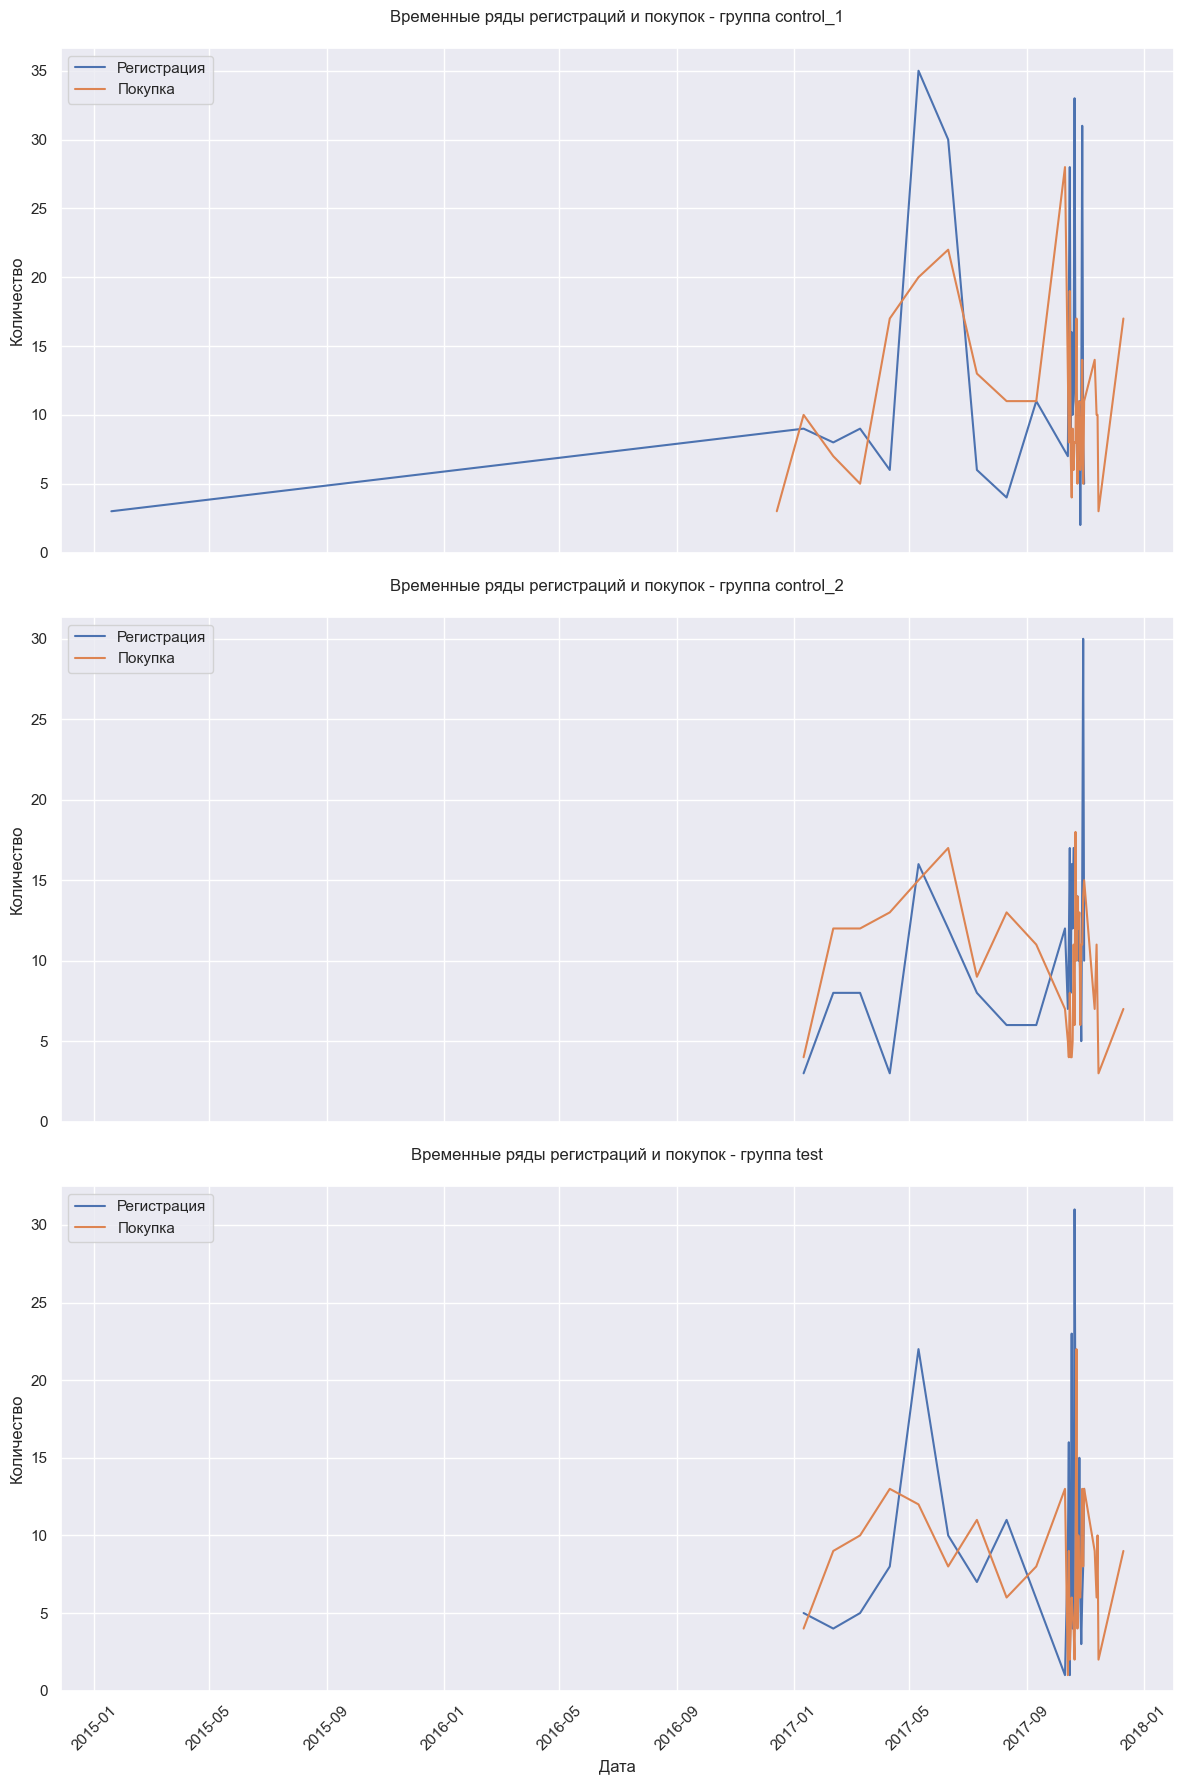

In [43]:
# построим графики дат по группам

df_date['joined_day'] = df_date['joined_at'].dt.date
df_date['paid_day'] = df_date['paid_at'].dt.date

df_joined = df_date.groupby(['joined_day', 'group']).size().reset_index(name='registrations')
df_paid = df_date.groupby(['paid_day', 'group']).size().reset_index(name='purchases')

sns.set(style="darkgrid")

fig, axes = plt.subplots(3, 1, figsize=(12, 18), sharex=True)

for i, group in enumerate(df_joined['group'].unique()):
    df_group_joined = df_joined[df_joined['group'] == group]
    df_group_paid = df_paid[df_paid['group'] == group]
    
    sns.lineplot(x='joined_day', y='registrations', data=df_group_joined, ax=axes[i], label='Регистрация')
    sns.lineplot(x='paid_day', y='purchases', data=df_group_paid, ax=axes[i], label='Покупка')
    
    axes[i].set_title(f'Временные ряды регистраций и покупок - группа {group}\n')
    axes[i].set_xlabel('Дата')
    axes[i].set_ylabel('Количество')
    axes[i].legend()
    axes[i].set_ylim(0)

plt.xticks(rotation=45)
plt.tight_layout()
plt.show()

In [44]:
# найдем выбросы в датах

filtered_data = df_trans[(df_trans['joined_at'] < '2017-01-11') & (df_trans['paid_at'] < '2017-01-11')]

filtered_data

,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group
326,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:30:00,26.0,0.0,refund_VP,other_type,control_1
360,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 17:35:00,637.0,0.0,refung_AP,other_type,control_1
477,960936960,Russian Federation,2015-01-19 11:49:00,2016-12-14 16:16:00,143.0,0.0,refund_WP,other_type,control_1


In [45]:
# удалим выбросы

df_trans = df_trans.drop(filtered_data.index)


 Еще в период с октября по ноябрь 2017 года наблюдаются резкие и частые перепады данных.

In [46]:
# добавим столбцы с месяцем покупки и регистрации

df_trans['month_registration'] = df_trans.joined_at.dt.month

df_trans['month_purchases'] = df_trans.paid_at.dt.month


In [47]:
# посчитаем количество регистраций по месяцам и группам

count_registration = df_trans.groupby(['group', 'month_registration'], as_index=False)['uid'].nunique()\
                             .rename(columns={'month_registration': 'month', 'uid': 'count_uid_registration'})


count_purchases = df_trans.groupby(['group', 'month_purchases'], as_index=False)['uid'].nunique()\
                             .rename(columns={'month_purchases': 'month', 'uid': 'count_uid_purchases'})


df_summary = pd.merge(count_registration, count_purchases, on=['group', 'month'], how='right')


sum_purchases = df_trans.groupby(['group', 'month_purchases'], as_index=False)['revenue'].sum()\
                        .rename(columns={'month_purchases': 'month'})

df_summary = pd.merge(df_summary, sum_purchases, on=['group', 'month'], how='right')

df_summary.sort_values('revenue',ascending=False)


,group,month,count_uid_registration,count_uid_purchases,revenue
9,control_1,10,120.0,104,1440166.0
33,test,10,100.0,84,1206413.0
21,control_2,10,135.0,103,1076907.0
34,test,11,NaN,25,310076.0
10,control_1,11,NaN,23,209599.0
32,test,9,NaN,8,148538.0
22,control_2,11,NaN,18,136045.0
4,control_1,5,15.0,16,132457.0
3,control_1,4,6.0,14,122863.0
16,control_2,5,13.0,13,121940.0


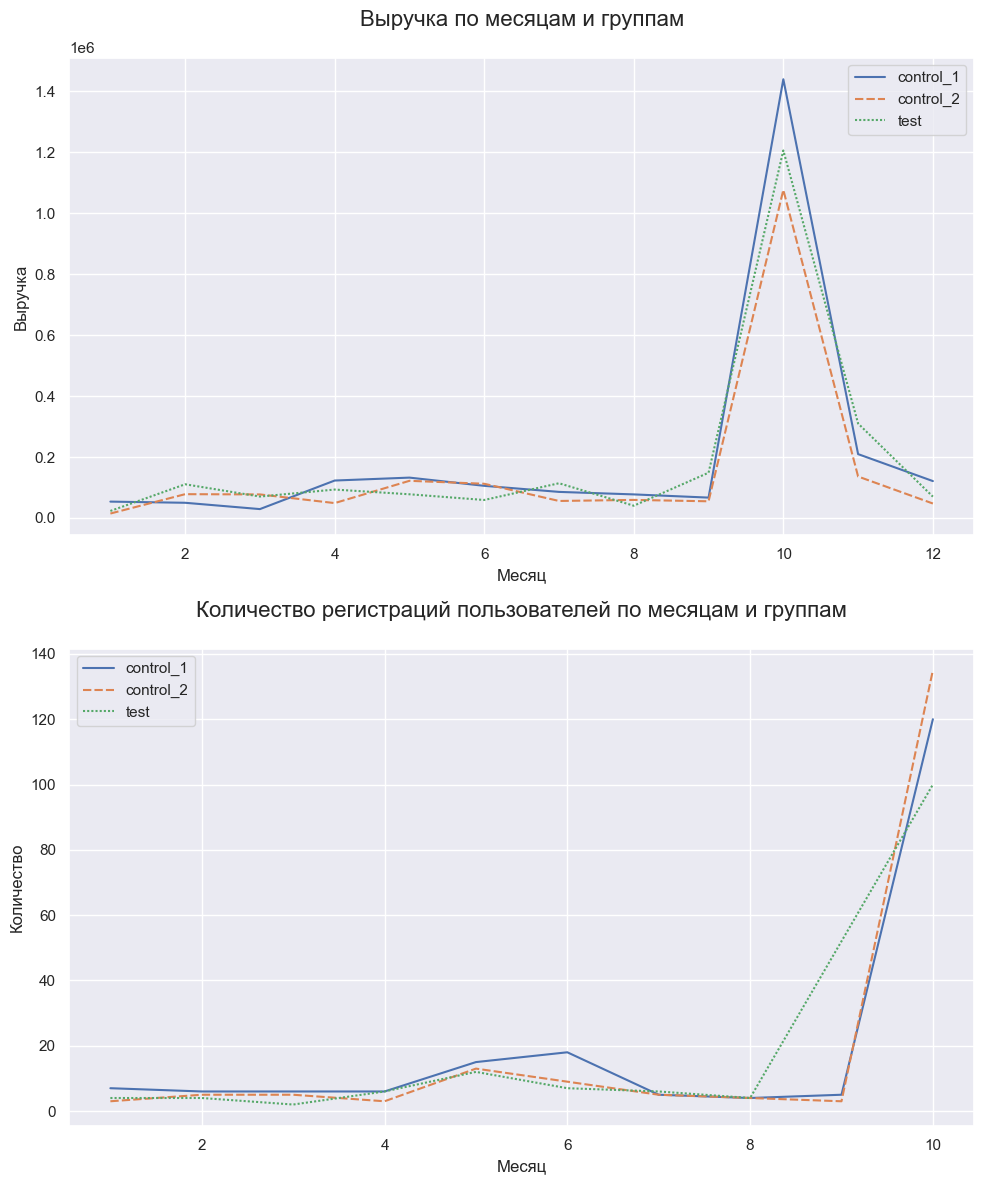

In [48]:
# построим два графика количества регистраций и выручки по месяцам

fig, axes = plt.subplots(nrows=2, ncols=1, figsize=(10, 12))

sns.lineplot(data=df_summary, x='month', y='revenue', hue='group', style='group', ax=axes[0])

axes[0].set_title('Выручка по месяцам и группам\n', fontsize=16)
axes[0].set_xlabel('Месяц')
axes[0].set_ylabel('Выручка')
axes[0].legend(labels=['control_1', 'control_2', 'test'])


sns.lineplot(data=df_summary, x='month', y='count_uid_registration', hue='group', style='group', ax=axes[1])

axes[1].set_title('Количество регистраций пользователей по месяцам и группам\n', fontsize=16)
axes[1].set_xlabel('Месяц')
axes[1].set_ylabel('Количество')
axes[1].legend(labels=['control_1', 'control_2', 'test'])

plt.tight_layout()
plt.show()


По полученным данным видим, что наибольшее количество регистраций и платежей происходит в октябре месяце, скорее всего в этот период проводился АВ-тест. 

### 2.2.2. Разница между датами регистрации и платежа.

In [49]:
# найдем разницу дней между датами регистрации и платежа

df_trans['days_since_registration'] = (df_trans.paid_at - df_trans.joined_at).dt.days


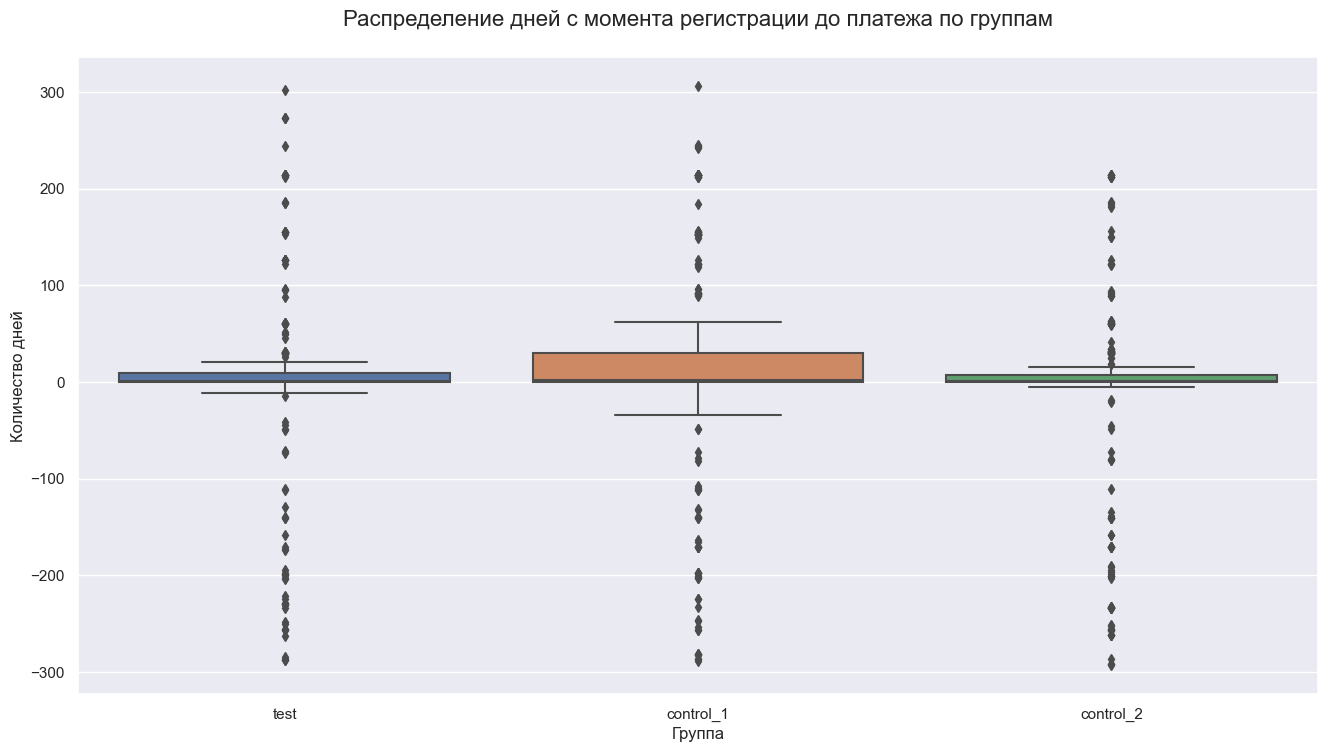

In [50]:
# построим график боксплот days_since_registration для всех групп 

sns.boxplot(x='group', y='days_since_registration', data=df_trans)

plt.xlabel('Группа')
plt.ylabel('Количество дней')
plt.title('Распределение дней с момента регистрации до платежа по группам\n', fontsize=16)

plt.show()

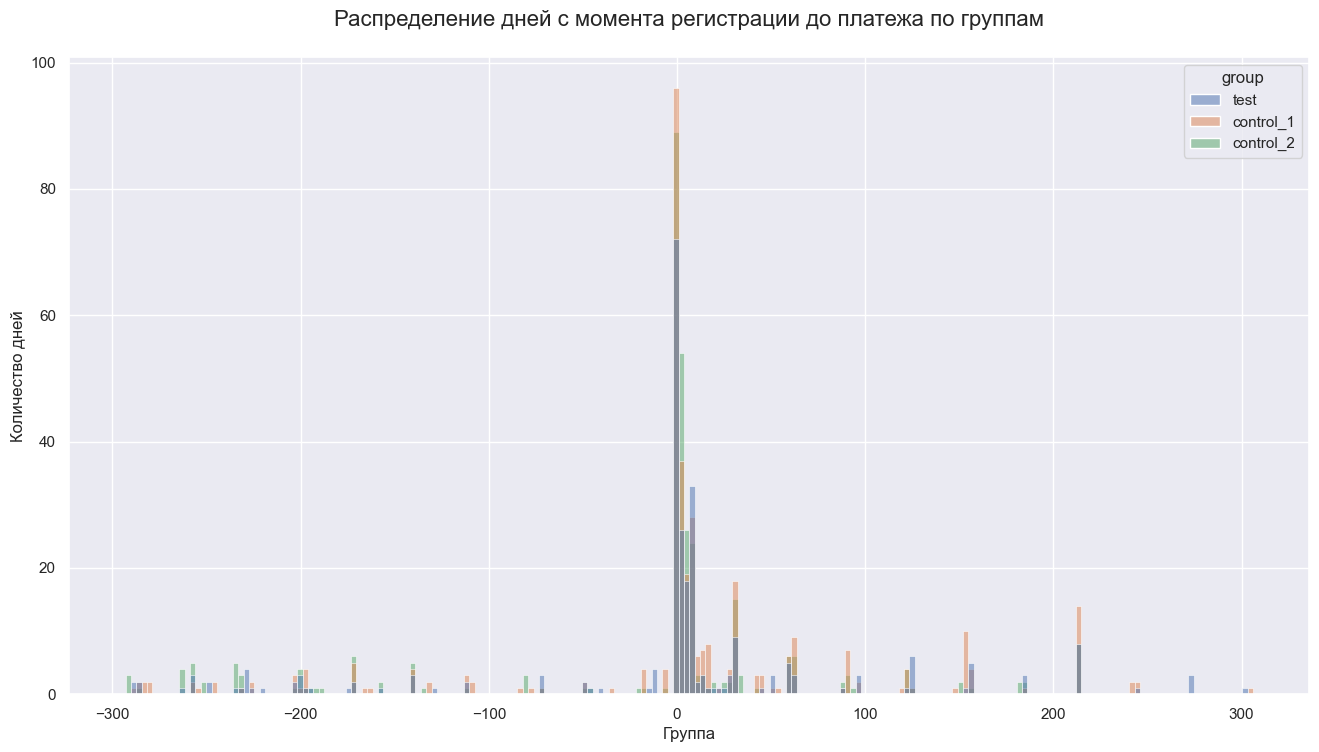

In [51]:
# построим график гистраграммы days_since_registration для всех групп

sns.histplot(data=df_trans, x="days_since_registration", hue = 'group')

plt.xlabel('Группа')
plt.ylabel('Количество дней')
plt.title('Распределение дней с момента регистрации до платежа по группам\n', fontsize=16)

plt.show()

Рассчитав количество дней с момента регистрации и до даты платежа, видим, что наибольшее количество платежей наблюдается в первый месяц после регистрации. Также стоит отметить, что есть дни со знаком минус, т.е. платеж был совершен до совершения регистрации пользователя в приложении. 

In [52]:
# отфильтруем данные когда дата платежа раньше даты регистрации

df_invalid_dates = df_trans[df_trans.paid_at < df_trans.joined_at]

# найдем какое количество пользователей и в какую дату совершили платеж раньше даты регистрации

count_invalid_dates = pd.DataFrame(df_invalid_dates.groupby(['group', 'paid_at'], as_index=False)['uid'].agg(list))

count_invalid_dates


,group,paid_at,uid
0,control_1,2017-01-11 02:56:00,[892145004]
1,control_1,2017-01-11 04:10:00,[892136748]
2,control_1,2017-01-11 04:34:00,[891908385]
3,control_1,2017-01-11 04:38:00,[892207959]
4,control_1,2017-01-11 04:39:00,[892207959]
...,...,...,...
146,test,2017-09-11 23:32:00,[891861594]
147,test,2017-10-11 15:24:00,[892065108]
148,test,2017-10-11 15:26:00,[892065108]
149,test,2017-10-11 15:27:00,"[892065108, 892065108]"


In [53]:
# посмотрим в какие дни было платеж раньше даты регистрации

count_invalid_dates.paid_at.dt.date.unique()


array([datetime.date(2017, 1, 11), datetime.date(2017, 2, 11),
       datetime.date(2017, 3, 11), datetime.date(2017, 4, 11),
       datetime.date(2017, 5, 11), datetime.date(2017, 6, 11),
       datetime.date(2017, 7, 11), datetime.date(2017, 8, 11),
       datetime.date(2017, 9, 11), datetime.date(2017, 10, 11)],
      dtype=object)

Не может быть, что в каждый месяц и именно 11 числа совершали платеж раньше регистрации, здесь скорее всего ошибка в формате даты, а именно число и месяц перепутаны местами.

In [54]:
# список дат, в которых нужно поменять число дня и месяца

date_paid_at = ['2017-1-11',
                '2017-2-11', 
                '2017-3-11', 
                '2017-4-11',
                '2017-5-11', 
                '2017-6-11', 
                '2017-7-11', 
                '2017-8-11', 
                '2017-9-11', 
                '2017-10-11' ]

df_trans['paid_at'] = df_trans['paid_at'].apply(lambda x: datetime.strftime(x, '%Y-%d-%m')\
                                                if (x.date() in pd.to_datetime(date_paid_at).date) and (df_trans['days_since_registration'] < 0).any() \
                                                else x)

df_trans['days_since_registration'] = (df_trans.paid_at - df_trans.joined_at).dt.days 

df_trans.query('days_since_registration < 0').uid.count()


0

### 2.2.3. Идентификатор платежа.

Из условия задачи , нужно учитывать условие для новых пользователей из нескольких стран была изменена стоимость премиум-подписки при покупке через две новые платежные системы. Далее определим эти две платежные системы. 

In [55]:
# посмотрим сколько всего платежных систем

df_trans.payment_id.unique()


array([147.,  67.,  19., 146.,  68.,   0., 127.])

In [56]:
# найдем количество пользователей проводившие транзакции по каждому  идентификатору платежа

df_trans.groupby(['group', 'payment_id'], as_index=False)\
        .agg({'uid': 'nunique'})\
        .pivot(index='group', columns='payment_id', values='uid')


payment_id,0.0,19.0,67.0,68.0,127.0,146.0,147.0
group,,,,,,,
control_1,2.0,47.0,27.0,17.0,1.0,31.0,152.0
control_2,1.0,50.0,33.0,13.0,NaN,30.0,140.0
test,1.0,37.0,15.0,10.0,NaN,29.0,118.0


In [57]:
# найдем количество пользователей проводившие транзакции по каждому  идентификатору платежа в разбивке по типу продукта

df_trans.groupby(['product_type','payment_id'], as_index=False)\
        .agg({'uid': 'nunique'})\
        .pivot(index='product_type', columns='payment_id', values='uid')


payment_id,0.0,19.0,67.0,68.0,127.0,146.0,147.0
product_type,,,,,,,
coins,NaN,129.0,NaN,NaN,NaN,90.0,NaN
other_type,NaN,5.0,75.0,4.0,1.0,NaN,NaN
premium_no_trial,4.0,NaN,NaN,36.0,NaN,NaN,231.0
trial_premium,NaN,NaN,NaN,NaN,NaN,NaN,180.0


In [58]:
# найдем количество пользователей проводившие транзакции по каждому  идентификатору платежа типу продукта premium_no_trial

df_trans.query('product_type == "premium_no_trial"')\
        .groupby(['group', 'payment_id'], as_index=False)\
        .agg({'uid': 'nunique'})\
        .pivot(index='group', columns='payment_id', values='uid')


payment_id,0.0,68.0,147.0
group,,,
control_1,2,15,85
control_2,1,13,88
test,1,8,58


In [59]:
# посмотрим пользователей,  которые совершили платежи через payment_id == 0.0

df_trans.query('payment_id == 0.0')


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group,month_registration,month_purchases,days_since_registration
211,891725043,United Arab Emirates,2017-10-29 00:49:00,2017-10-29 07:48:00,9217.0,0.0,none,premium_no_trial,test,10,10,0
397,891216033,United States of America,2017-07-11 12:33:00,2017-11-07 00:00:00,6292.0,0.0,autoreply_message,premium_no_trial,control_1,7,7,118
589,892101909,France,2017-10-21 03:28:00,2017-10-21 03:39:00,6422.0,0.0,none,premium_no_trial,control_1,10,10,0
707,891219540,Australia,2017-07-11 10:50:00,2017-11-07 00:00:00,4719.0,0.0,none,premium_no_trial,control_2,7,7,118


In [60]:
# посмотрим пользователей,  которые совершили платежи через payment_id == 0.0 какие еще совершили платежи

df_trans.query('uid in [891725043, 892101909, 891219540, 891216033]').sort_values('uid')


,uid,country,joined_at,paid_at,revenue,payment_id,from_page,product_type,group,month_registration,month_purchases,days_since_registration
397,891216033,United States of America,2017-07-11 12:33:00,2017-11-07 00:00:00,6292.0,0.0,autoreply_message,premium_no_trial,control_1,7,7,118
520,891216033,United States of America,2017-07-11 12:33:00,2017-11-07 00:00:00,6292.0,147.0,autoreply_message,premium_no_trial,control_1,7,7,118
707,891219540,Australia,2017-07-11 10:50:00,2017-11-07 00:00:00,4719.0,0.0,none,premium_no_trial,control_2,7,7,118
760,891219540,Australia,2017-07-11 10:50:00,2017-11-07 00:00:00,4719.0,147.0,none,premium_no_trial,control_2,7,7,118
146,891725043,United Arab Emirates,2017-10-29 00:49:00,2017-10-29 07:48:00,9217.0,147.0,none,premium_no_trial,test,10,10,0
211,891725043,United Arab Emirates,2017-10-29 00:49:00,2017-10-29 07:48:00,9217.0,0.0,none,premium_no_trial,test,10,10,0
415,892101909,France,2017-10-21 03:28:00,2017-10-23 22:32:00,741.0,146.0,empty_likes,coins,control_1,10,10,2
446,892101909,France,2017-10-21 03:28:00,2017-10-23 22:35:00,923.0,19.0,none,coins,control_1,10,10,2
465,892101909,France,2017-10-21 03:28:00,2017-10-21 03:39:00,6422.0,147.0,none,premium_no_trial,control_1,10,10,0
589,892101909,France,2017-10-21 03:28:00,2017-10-21 03:39:00,6422.0,0.0,none,premium_no_trial,control_1,10,10,0


Данные о транзакциях: 

1. Данные транзакций по странам сделала в соответствии с датафреймом о пользователях .

2. Привела данные к одному временному периоду с января по декабрь 2017, а также можем предположить, что в октябре проводилось АВ-тестирование. 

3. В данных о разнице между датами регистрации и платежа были исправлены даты, которые давали отрацательное значение разницы этих дат, т.е. когда платеж  раньше регистрации.

4. По условию задачи, тест проводился по двум новым платежам, поэтому можно предположить, что 68.0 и 147.0 ими являются. 0.0 систему платежей не берем, так как данные платежи продублированы  147.0 системой. 

По условию задачи "Был проведен A/B тест, в рамках которого для новых пользователей из нескольких стран была изменена стоимость премиум-подписки* при покупке через две новые платежные системы", поэтому для дальнейшего анализа  отфильтруем данные. Страны мы уже отфильтровали, что касается новых пользователей, то при анализе дат я предположу, что в октябре проводился тест, поэтому зарегистрировавшие с октября  - это и будут новые пользователи. На счет платежных систем, то я описала это выше. 

In [61]:
# итоговый датафрейм

df_trans = df_trans.query('month_registration >= 10').query('payment_id in [147.0, 68.0]')


In [62]:
df_trans.groupby('group', as_index=False)['uid'].nunique()

,group,uid
0,control_1,105
1,control_2,110
2,test,90


In [63]:
df_trans.groupby(['group', 'product_type'],as_index=False)['uid'].count()

,group,product_type,uid
0,control_1,other_type,1
1,control_1,premium_no_trial,66
2,control_1,trial_premium,42
3,control_2,premium_no_trial,74
4,control_2,trial_premium,40
5,test,other_type,2
6,test,premium_no_trial,55
7,test,trial_premium,42


# 3. Оценка успешности A/B теста.

Для оценки успешности A/B теста и проверки, был ли эксперимент успешен в целом, можно выполнить следующие шаги:

1. Сравнить конверсию в покупку (СR) для каждой группы, как отношение числа пользователей, совершивших покупку премиум-подписки, к общему числу пользователей в группе.

2. Сравнить средний доход на одного платящего пользователя совершивших покупку премиум-подписки  (ARPPU). 

3. Сравнить средний доход с привлечённого пользователя, как умножение конверсии на средний доход одного платящего пользователя совершивших покупку премиум-подписки (ARPU).

Сравнение результатов используя статистические тесты для определения статистической значимости различий между группами. Если тестовая группа показывает статистически значимые и положительные результаты по сравнению с контрольными группами, можно сделать вывод о успешности эксперимента. Можем выдвинуть гипотезы следующим образом:

Н0: Нет статистически значимой разницы между метрикой в каждой группе.

Н1: Метрики в группах статистически значимо различаются.

Также для каждой метрики сначала проведем АА-тест - это позволяет оценить стабильность и надежность системы тестирования, а также проверить, что случайное разделение на группы работает корректно. Во время A/A-тестирования должны убедиться, что нет статистически значимых различий между двумя контрольными группами.

## 3.1. Сравнение конверсии в покупку премиум-подписки.

In [64]:
# найдем количество пользователей в категории "premium_no_trial"

group_uid_trial_premium = df_trans.query('product_type == "premium_no_trial"')\
                                                .groupby('group', as_index=False)['uid'].nunique()\
                                                .rename(columns = ({'uid': 'uid_premium'}))


# общее количество пользователей в каждой группе, которые не приобрели премиум-подписку

group_uid_no_trial_premium = df_trans.query('product_type != "premium_no_trial"')\
                         .groupby('group', as_index=False).agg({'uid': 'nunique'})\
                         .rename(columns = ({'uid': 'uid_no_premium'}))


# объеденим общее количество пользователей и пользователей в категории "trial_premium"

group_trial_merge = pd.merge(group_uid_no_trial_premium, group_uid_trial_premium, on='group')

# расчет конверсии

group_trial_merge['total_uid'] = group_trial_merge[['uid_no_premium', 'uid_premium']].sum(axis=1)

group_trial_merge['CR'] = round((group_trial_merge['uid_premium'] / group_trial_merge['total_uid']) * 100,2)

group_trial_merge


,group,uid_no_premium,uid_premium,total_uid,CR
0,control_1,43,62,105,59.05
1,control_2,40,70,110,63.64
2,test,44,47,91,51.65


Гипотезы АА-теста:

Н0: Конверсии контрольных групп статистически значимо не отличаются.

Н1: Конверсии контрольных групп имеют статистически значимые отличия.

In [65]:
#  подготовим данные для теста хи-квадрат

df_trans = df_trans.assign(is_premium=df_trans['product_type'].apply(lambda x: 1 if x == 'premium_no_trial' else 0))

tab_data = df_trans.query('group != "test"')\
                   .groupby(['is_premium', 'group'], as_index=False)\
                   .agg({'uid': 'nunique'})\
                   .pivot(columns='group', index='is_premium').droplevel(0, axis=1)


tab_data.loc[0] = tab_data.sum(axis=0)

tab_data


group,control_1,control_2
is_premium,,
0,105,110
1,62,70


In [66]:
#  проведем тест ХИ-квадрат 

chi2_contingency(tab_data)


(0.051694837656141635,
 0.8201399430949599,
 1,
 array([[103.47262248, 111.52737752],
        [ 63.52737752,  68.47262248]]))

p-value теста хи-квадрат составляет 0.82, нет оснований отклонить нулевую гипотезу АА-теста следовательно можно предположить, что платформа для тестирования работает правильно.

In [67]:
#  подготовим данные для теста хи-квадрат АВ-теста

tab_data_АВ = df_trans\
                   .groupby(['is_premium', 'group'], as_index=False)\
                   .agg({'uid': 'nunique'})\
                   .pivot(columns='group', index='is_premium').droplevel(0, axis=1)


tab_data_АВ.loc[0] = tab_data_АВ.sum(axis=0)

tab_data_АВ


group,control_1,control_2,test
is_premium,,,
0,105,110,91
1,62,70,47


In [68]:
# хи-квадрат АВ-теста

chi2_contingency(tab_data_АВ)


(0.7880992808654579,
 0.6743205818441285,
 2,
 array([[105.36494845, 113.56701031,  87.06804124],
        [ 61.63505155,  66.43298969,  50.93195876]]))

Хи-квадрат АВ - теста также не показал значимых различий конверсий (p-value = 0.67)между тестовой и контрольными группами, следовательно изменение цены на премиум-подписку значимо не повлияло на конверсию в покупку новых пользователей.

## 3.2. Сравнение показателей ARPPU и ARPU.

In [69]:
# распределение покупок по группам

df_trans.groupby(['group','product_type']).agg({'uid': 'nunique', 'revenue': 'sum'})


uid   revenue
group     product_type                   
control_1 other_type          1   30264.0
          premium_no_trial   62  501384.0
          trial_premium      42  486330.0
control_2 premium_no_trial   70  560248.0
          trial_premium      40  491556.0
test      other_type          2   45149.0
          premium_no_trial   47  534989.0
          trial_premium      42  535470.0

In [70]:
# посмотрим статистическое описание общего дохода

df_trans[['revenue', 'group']].groupby('group').describe()


revenue                                                      \
            count          mean           std     min     25%     50%   
group                                                                   
control_1   109.0   9339.247706   9315.971312  1508.0  5525.0  6409.0   
control_2   114.0   9226.350877   9291.458538  2015.0  6292.0  6350.5   
test         99.0  11268.767677  11247.285241  1898.0  7637.5  9477.0   

                              
               75%       max  
group                         
control_1  10556.0   63037.0  
control_2  10692.5   81796.0  
test       12727.0  113477.0

In [71]:
# посмотрим статистическое описание  дохода от премиум-подписки

df_revenue = df_trans.query('product_type=="premium_no_trial" and revenue > 0')

df_revenue[['revenue', 'group']].groupby('group').describe()


revenue                                                              \
            count         mean           std     min      25%     50%     75%   
group                                                                           
control_1    66.0  7596.727273  11287.972950  1508.0  4537.00  6292.0  6292.0   
control_2    74.0  7570.918919  11061.589525  2015.0  4826.25  6292.0  6292.0   
test         55.0  9727.072727  14600.402138  1898.0  5388.50  8086.0  9379.5   

                     
                max  
group                
control_1   63037.0  
control_2   81796.0  
test       113477.0

Исходя из этих данных, можно сделать предварительный вывод, что тестовая группа  имеет наибольшую выручку как в общем, так и от премиум-подписки. Однако, для окончательных выводов необходимо провести статистическую проверку гипотез.

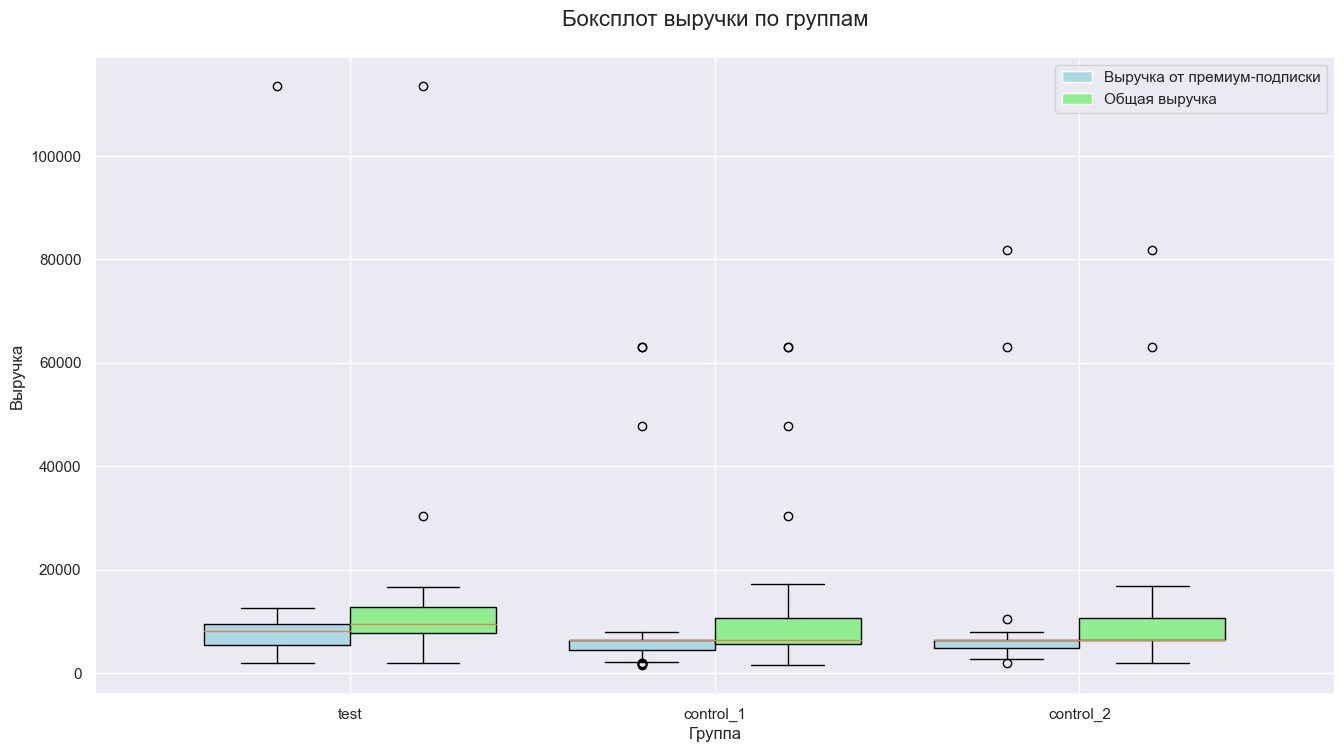

In [72]:
# Построим боксплоты общей выручки и выручки премиум-подписки

fig, ax = plt.subplots()

ax.boxplot([df_revenue[df_revenue['group'] == 'test']['revenue'],
            df_revenue[df_revenue['group'] == 'control_1']['revenue'],
            df_revenue[df_revenue['group'] == 'control_2']['revenue']],
           positions=[1, 2, 3], widths=0.4, patch_artist=True, boxprops=dict(facecolor='lightblue'))

ax.boxplot([df_trans[df_trans['group'] == 'test']['revenue'],
            df_trans[df_trans['group'] == 'control_1']['revenue'],
            df_trans[df_trans['group'] == 'control_2']['revenue']],
           positions=[1.4, 2.4, 3.4], widths=0.4, patch_artist=True, boxprops=dict(facecolor='lightgreen'))

ax.set_xticks([1.2, 2.2, 3.2])
ax.set_xticklabels(['test', 'control_1', 'control_2'])
ax.set_title('Боксплот выручки по группам\n', fontsize=16)
ax.set_xlabel('Группа')
ax.set_ylabel('Выручка')

box1 = plt.Rectangle((0, 0), 1, 1, fc='lightblue')
box2 = plt.Rectangle((0, 0), 1, 1, fc='lightgreen')
ax.legend([box1, box2], ['Выручка от премиум-подписки', 'Общая выручка'], loc='upper right')

plt.show()


На графиках видим явные выбросы в каждой группе. Распределения контрольных групп похожи.

In [73]:
# подготовка данных для расчета метрик

other_df = df_trans.query('product_type != "premium_no_trial"')\
                   .groupby('uid', as_index=False)\
                   .agg(other_revenue= ('revenue','sum'))

premium_df = df_trans.query('product_type == "premium_no_trial"')\
                     .groupby('uid', as_index=False)\
                     .agg(premium_revenue = ('revenue', 'sum'))
                 

data = df_trans[['uid', 'revenue', 'product_type', 'group', 'is_premium']]
    
data = data.merge(other_df, how='left', on='uid').merge(premium_df, how='left', on='uid').fillna(0)

# общая выручка
data['total_revenue']= data.other_revenue + data.premium_revenue
# был ли платеж
data['is_payment'] = np.where(data.total_revenue == 0, "no_payment", "payment")
# был ли платеж премиум подписки
data['is_premium_payment'] = np.where(data.premium_revenue == 0, "no_premium_payment", "premium_payment")
# был ли платеж другой подписки
data['is_other_payment'] = np.where(data.other_revenue == 0, "no_other_payment", "other_payment")


In [74]:
# проверим полученный датафрейм на дубликаты

data['uid'].duplicated().sum()


17

In [75]:
# удалим дубликаты

data.drop_duplicates(subset='uid', inplace=True)


In [76]:
# расчет метрик

def calculate_metrics(data, group):
    
    metrics = pd.DataFrame()
    
    # Конверсия
    metrics['conversion'] = data[data['is_premium_payment'] == 'premium_payment'].groupby(group).uid.nunique() / data.groupby(group).uid.nunique()
    
    # ARPPU
    # Расчет общего количества платежей премиум подписки и общего дохода от платежей премиум подписки
    total_premium_payments = data[data['is_premium_payment'] == 'premium_payment'].groupby(group)['uid'].nunique()
    total_premium_revenue = data[data['is_premium_payment'] == 'premium_payment'].groupby(group)['premium_revenue'].sum()
    # Расчет среднего чека платежа премиум подписки
    metrics['arppu'] = total_premium_revenue / total_premium_payments
    
    # ARPU
    metrics['arpu'] = metrics['conversion'] * metrics['arppu']
    
    metrics = metrics.round(2)
    
    return metrics


In [77]:

data_metric = calculate_metrics(data, 'group').reset_index()

data_metric


,group,conversion,arppu,arpu
0,control_1,0.59,8086.84,4775.09
1,control_2,0.64,8003.54,5093.16
2,test,0.52,11382.74,5944.32


In [78]:
# посмотрим процент отличия метрик тестовой группы от контрольных групп

control_1_conversion = data_metric[data_metric['group'] == 'control_1']['conversion'].values[0]
control_1_arppu = data_metric[data_metric['group'] == 'control_1']['arppu'].values[0]
control_1_arpu = data_metric[data_metric['group'] == 'control_1']['arpu'].values[0]

control_2_conversion = data_metric[data_metric['group'] == 'control_2']['conversion'].values[0]
control_2_arppu = data_metric[data_metric['group'] == 'control_2']['arppu'].values[0]
control_2_arpu = data_metric[data_metric['group'] == 'control_2']['arpu'].values[0]

test_conversion = data_metric[data_metric['group'] == 'test']['conversion'].values[0]
test_arppu = data_metric[data_metric['group'] == 'test']['arppu'].values[0]
test_arpu = data_metric[data_metric['group'] == 'test']['arpu'].values[0]

conversion_difference_1 = (test_conversion - control_1_conversion) / control_1_conversion * 100
arppu_difference_1 = (test_arppu - control_1_arppu) / control_1_arppu * 100
arpu_difference_1 = (test_arpu - control_1_arpu) / control_1_arpu * 100

conversion_difference_2 = (test_conversion - control_2_conversion) / control_2_conversion * 100
arppu_difference_2 = (test_arppu - control_2_arppu) / control_2_arppu * 100
arpu_difference_2 = (test_arpu - control_2_arpu) / control_2_arpu * 100

print("Процент отличия тестовой группы от контрольной группы 1:")
print("Conversion: {:.2f}%".format(conversion_difference_1))
print("ARPPU: {:.2f}%".format(arppu_difference_1))
print("ARPU: {:.2f}%".format(arpu_difference_1))
print()
print("Процент отличия тестовой группы от контрольной группы 2:")
print("Conversion: {:.2f}%".format(conversion_difference_2))
print("ARPPU: {:.2f}%".format(arppu_difference_2))
print("ARPU: {:.2f}%".format(arpu_difference_2))


Процент отличия тестовой группы от контрольной группы 1:
Conversion: -11.86%
ARPPU: 40.76%
ARPU: 24.49%

Процент отличия тестовой группы от контрольной группы 2:
Conversion: -18.75%
ARPPU: 42.22%
ARPU: 16.71%


Эти результаты показывают, что в тестовой группе наблюдается снижение конверсии по сравнению с обеими контрольными группами, однако процент отличия в ARPPU и ARPU между тестовой группой и контрольными группами указывает на то, что в тестовой группе пользователи приносят больше дохода по сравнению с контрольными группами. 

In [79]:
# создадим датафрейм содержащий значения метрик для каждой итерации бутстрэп,
# для дальнейшего анализа и оценки значений ARPPU и ARPU.

iterations = 5000
bootstrap_df = pd.DataFrame()
boot_data_arppu1 = []
boot_data_arppu2 = []
boot_data_arpu1 = []
boot_data_arpu2 = []

for x in range(iterations):
    iter_df = data.sample(frac=1, replace=True).groupby(['group'], as_index=False).apply(lambda x: pd.Series({
        
        'conversion': x[x['is_premium_payment'] == 'premium_payment']['uid'].nunique() / x['uid'].nunique(),
        
        'arppu': x[x['is_premium_payment'] == 'premium_payment']['premium_revenue'].sum() / x[x['is_premium_payment'] == 'premium_payment']['uid'].nunique(),

        'arpu': (x[x['is_premium_payment'] == 'premium_payment']['uid'].nunique() / x['uid'].nunique()) * (x[x['is_premium_payment'] == 'premium_payment']['premium_revenue'].sum() / x[x['is_premium_payment'] == 'premium_payment']['uid'].nunique())
    }))

    control_1_iter_df = iter_df[iter_df['group'] == 'control_1'].reset_index(drop=True)
    control_2_iter_df = iter_df[iter_df['group'] == 'control_2'].reset_index(drop=True)
    test_iter_df = iter_df[iter_df['group'] == 'test'].reset_index(drop=True)

    bootstrap_df = pd.concat([bootstrap_df, iter_df])
    

In [80]:
bootstrap_df.head()

,group,conversion,arppu,arpu
0,control_1,0.583333,12069.200000,7040.366667
1,control_2,0.633803,12962.444444,8215.633803
2,test,0.610169,12737.472222,7772.016949
0,control_1,0.553846,9829.444444,5444.000000
1,control_2,0.662162,11512.163265,7622.918919


In [81]:
mean_conversion_by_group = bootstrap_df.groupby('group')['conversion'].mean()
mean_arppu_by_group = bootstrap_df.groupby('group')['arppu'].mean()
mean_arpu_by_group = bootstrap_df.groupby('group')['arpu'].mean()

print('Среднее значение Conversion по группам:')
print(mean_conversion_by_group)
print()
print('Среднее значение ARPPU по группам:')
print(mean_arppu_by_group)
print()
print('Среднее значение ARPU по группам:')
print(mean_arpu_by_group)


Среднее значение Conversion по группам:
group
control_1    0.591170
control_2    0.636925
test         0.522023
Name: conversion, dtype: float64

Среднее значение ARPPU по группам:
group
control_1    12700.031696
control_2    12690.661937
test         17964.564778
Name: arppu, dtype: float64

Среднее значение ARPU по группам:
group
control_1    7508.602096
control_2    8081.829254
test         9379.325168
Name: arpu, dtype: float64


Выбросы в исходных данных могут существенно влиять на среднее значение метрик и, следовательно, на отклонение после бутстрэп-анализа.

Для определения статистической значимости различий в ARPPU и ARPU между тестовой и контрольными группами часто применяется T-критерий Стьюдента. Однако, при использовании T-критерия Стьюдента, необходимо учитывать требование гомогенности дисперсий внутри групп.
Для проверки гомогенности дисперсий можно использовать критерий Левена.

Гипотеза критерия Левена звучит следующим образом:
H0: Дисперсии внутри всех групп равны (гомогенность дисперсий).
H1: Дисперсии внутри групп не равны (гетерогенность дисперсий).

Если результаты критерия Левена показывают, что дисперсии внутри групп не являются гомогенными, то применение T-критерия Стьюдента может быть неправильным и применение бутстрап окажется лучше и адекватнее.

In [82]:
# применим критерий Левена

data_arppu = bootstrap_df[['group', 'arppu']]
data_arpu = bootstrap_df[['group', 'arpu']]

levene_arppu = pg.homoscedasticity(data=data_arppu, dv='arppu', group='group')
levene_arpu = pg.homoscedasticity(data=data_arpu, dv='arpu', group='group')

print(levene_arppu)
print(levene_arpu)


                 W           pval  equal_var
levene  571.659908  5.492606e-240      False
                 W           pval  equal_var
levene  299.473205  2.954204e-128      False


Результаты теста Левена показывают, что группы не имеют гомогенных дисперсий для обоих показателей (ARPPU и ARPU). Значение p-значения для обоих тестов очень мало (меньше 0.05), что говорит о статистически значимом различии в дисперсиях между группами.
Таким образом, можно сделать вывод, что группы не являются гомогенными по показателям ARPPU и ARPU, поэтому применим бутстреп. 

In [83]:
# бутсреп-анализ метрик, найдем p-значения с использованием функции norm.cdf 

iterations = 5000
bootstrap_df = pd.DataFrame()
boot_data_arppu1 = []
boot_data_arppu2 = []
boot_data_arpu1 = []
boot_data_arpu2 = []

for x in range(iterations):
    iter_df = data.sample(frac=1, replace=True).groupby(['group'], as_index=False).apply(lambda x: pd.Series({
        
        'conversion': x[x['is_premium_payment'] == 'premium_payment']['uid'].nunique() / x['uid'].nunique(),
        
        'arppu': x[x['is_premium_payment'] == 'premium_payment']['premium_revenue'].sum() / x[x['is_premium_payment'] == 'premium_payment']['uid'].nunique(),

        'arpu': (x[x['is_premium_payment'] == 'premium_payment']['uid'].nunique() / x['uid'].nunique()) * (x[x['is_premium_payment'] == 'premium_payment']['premium_revenue'].sum() / x[x['is_premium_payment'] == 'premium_payment']['uid'].nunique())
    }))

    control_1_iter_df = iter_df[iter_df['group'] == 'control_1'].reset_index(drop=True)
    control_2_iter_df = iter_df[iter_df['group'] == 'control_2'].reset_index(drop=True)
    test_iter_df = iter_df[iter_df['group'] == 'test'].reset_index(drop=True)

    bootstrap_df = pd.concat([bootstrap_df, iter_df])
    
    # Вычисление p-значения для ARPPU
    
    boot_data_arppu1.append(np.mean(test_iter_df['arppu']) - np.mean(control_1_iter_df['arppu']))

    p_1 = norm.cdf(
        x=0,
        loc=np.mean(boot_data_arppu1),
        scale=np.std(boot_data_arppu1)
    )
    p_2 = norm.cdf(
        x=0,
        loc=-np.mean(boot_data_arppu1),
        scale=np.std(boot_data_arppu1)
    )
    p_value_arppu_1 = min(p_1, p_2) * 2
    
    boot_data_arppu2.append(np.mean(test_iter_df['arppu']) - np.mean(control_2_iter_df['arppu']))

    p_1 = norm.cdf(
        x=0,
        loc=np.mean(boot_data_arppu2),
        scale=np.std(boot_data_arppu2)
    )
    p_2 = norm.cdf(
        x=0,
        loc=-np.mean(boot_data_arppu2),
        scale=np.std(boot_data_arppu2)
    )
    p_value_arppu_2 = min(p_1, p_2) * 2
    
    # Вычисление p-значения для ARPU
    boot_data_arpu1.append(np.mean(test_iter_df['arpu']) - np.mean(control_1_iter_df['arpu']))

    p_1 = norm.cdf(
        x=0,
        loc=np.mean(boot_data_arpu1),
        scale=np.std(boot_data_arpu1)
    )
    p_2 = norm.cdf(
        x=0,
        loc=-np.mean(boot_data_arpu1),
        scale=np.std(boot_data_arpu1)
    )
    p_value_arpu_1 = min(p_1, p_2) * 2
    
    boot_data_arpu2.append(np.mean(test_iter_df['arpu']) - np.mean(control_2_iter_df['arpu']))

    p_1 = norm.cdf(
        x=0,
        loc=np.mean(boot_data_arpu2),
        scale=np.std(boot_data_arpu2)
    )
    p_2 = norm.cdf(
        x=0,
        loc=-np.mean(boot_data_arpu2),
        scale=np.std(boot_data_arpu2)
    )
    p_value_arpu_2= min(p_1, p_2) * 2

print('p_value_arppu1', p_value_arppu_1)
print('p_value_arppu2', p_value_arppu_2)
print('p_value_arpu1', p_value_arpu_1)
print('p_value_arpu2', p_value_arpu_2)


p_value_arppu1 0.2737567192547897
p_value_arppu2 0.2529713930594433
p_value_arpu1 0.5014702477362427
p_value_arpu2 0.6252508643398811


Для метрики ARPPU, p_value_arppu1 и p_value_arppu2 превышают уровень значимости 0.05, что означает, что различия в ARPPU между тестовой группой и контрольными группами не являются статистически значимыми. То есть, изменения, внесенные в тестовую группу, не имеют значительного влияния на ARPPU.

Для метрики ARPU, p_value_arpu1 и p_value_arpu2 также превышают уровень значимости 0.05, что указывает на отсутствие статистически значимых различий в ARPU между тестовой группой и контрольными группами. Таким образом, изменения в тестовой группе не оказывают значительного влияния на ARPU.

В целом, мы не можем сделать вывод о статистически значимых различиях в доходности между тестовой группой и контрольными группами. 

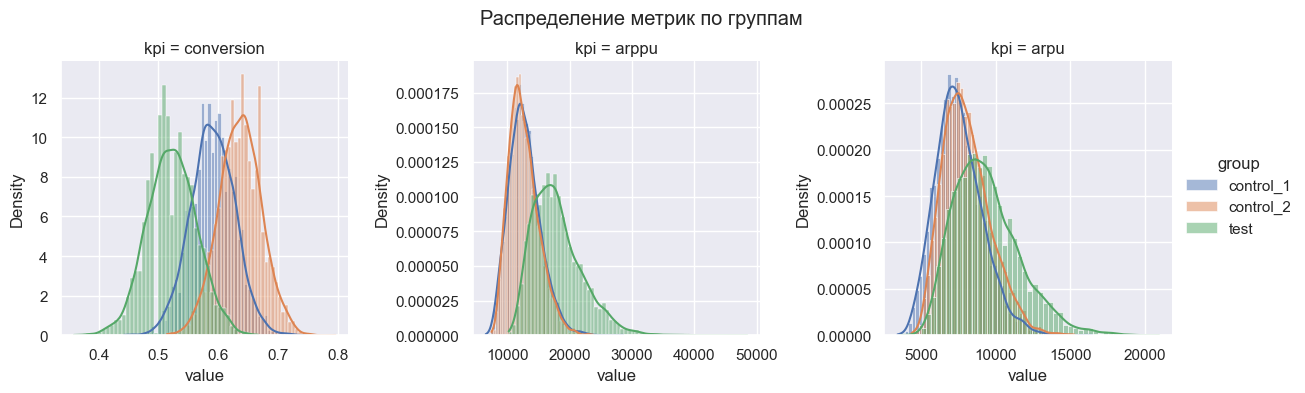

In [84]:
# построим график распределения значений метрик

bootstrap_df_melt = pd.melt(bootstrap_df, id_vars = 'group', value_vars = ['conversion', 'arppu', 'arpu'], var_name = 'kpi')

plot = sns.FacetGrid(bootstrap_df_melt, col="kpi", sharex = False, sharey = False, height = 4, hue = 'group')
plot.map_dataframe(sns.histplot, x="value", kde = True, stat = 'density', common_bins = True, fill = True)
plot.add_legend()

plot.fig.suptitle("Распределение метрик по группам \n")
plot.fig.subplots_adjust(top=0.85)
plt.show()


Конверсия тестовой группы показывает результат хуже, чем в контрольных группах. А метрики доходности тестовой группы наоборот показывают результат лучше, чем в контрольных группах. Для разницы ключевых показателей эффективности между контрольными и тестовой группами мы определим 95% доверительный интервал, который даст ответ на то, как изменились показатели между группами.

In [85]:
# найдем доверительный интервал

bootstrap_control_1 = bootstrap_df[bootstrap_df['group'] == 'control_1'].reset_index()
bootstrap_control_2 = bootstrap_df[bootstrap_df['group'] == 'control_2'].reset_index()
bootstrap_test = bootstrap_df[bootstrap_df['group'] == 'test'].reset_index()

bootstrap_diffs = pd.DataFrame()
bootstrap_diffs['conversion_diff_1'] = bootstrap_test['conversion'] - bootstrap_control_1['conversion']
bootstrap_diffs['conversion_diff_2'] = bootstrap_test['conversion'] - bootstrap_control_2['conversion']
bootstrap_diffs['arpu_diff_1'] = bootstrap_test['arpu'] - bootstrap_control_1['arpu']
bootstrap_diffs['arpu_diff_2'] = bootstrap_test['arpu'] - bootstrap_control_2['arpu']
bootstrap_diffs['arppu_diff_1'] = bootstrap_test['arppu'] - bootstrap_control_1['arppu']
bootstrap_diffs['arppu_diff_2'] = bootstrap_test['arppu'] - bootstrap_control_2['arppu']

bootstrap_diffs_melt = pd.melt(bootstrap_diffs, value_vars=['conversion_diff_1', 'conversion_diff_2', 'arpu_diff_1', 'arpu_diff_2', 'arppu_diff_1', 'arppu_diff_2'], var_name='kpi')


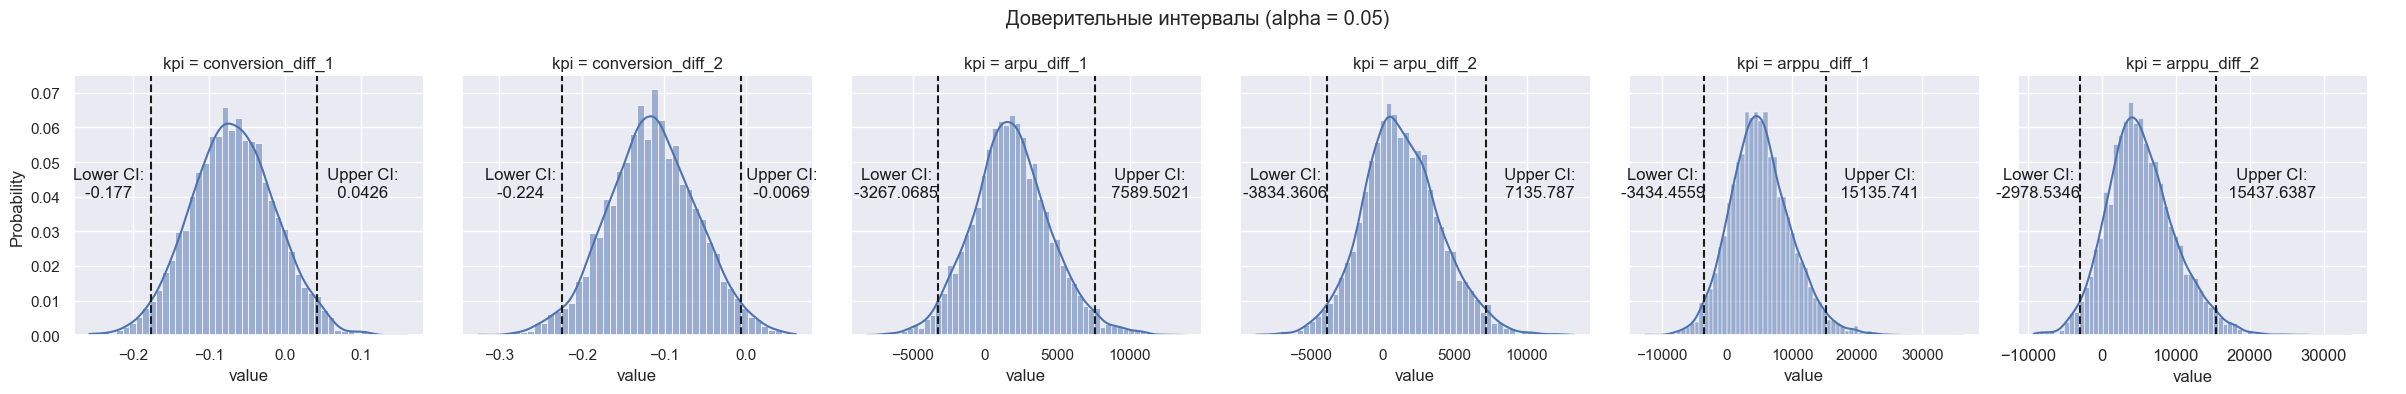

In [86]:
# построим графики распределение различий между группами с доверительными интервалами.

alpha = 0.05
lower_ci = alpha/2
upper_ci = 1 - (alpha/2)

plot = sns.FacetGrid(bootstrap_diffs_melt, col="kpi", sharex=False, sharey=True, height=4)
plot.map_dataframe(sns.histplot, x="value", kde=True, stat='probability', common_bins=True, fill=True)
plot.fig.suptitle('Доверительные интервалы (alpha = ' + str(alpha) + ')')

plot = plot.map(lambda y, **kw: plt.axvline(y.quantile(lower_ci), color='k', linestyle='--'), 'value')
plot = plot.map(lambda y, **kw: plt.axvline(y.quantile(upper_ci), color='k', linestyle='--'), 'value')

plot = plot.map(lambda y, **kw: plt.text(y.quantile(lower_ci), 0.04, 'Lower CI:' + ' ' * 18 + '\n' + str(round(y.quantile(lower_ci), 4)) + ' ' * 18, color='k', ha='center'), 'value')
plot = plot.map(lambda y, **kw: plt.text(y.quantile(upper_ci)*1.125, 0.04, ' ' * 18 + 'Upper CI:\n' + ' ' * 18 + str(round(y.quantile(upper_ci), 4)), color='k', ha='center'), 'value')

plot.add_legend()

plt.tick_params(axis='both', which='major', labelsize=12)


Во всех графиках ноль попадает в доверительный интервал с alpha = 0.05( кроме графика conversion_diff_2), поэтому не можем отвергнуть нулевую гипотезу, что и показали значения p-value. 
Но, какова вероятность, что тестовая группа будет хуже, чем контрольные группы.

In [87]:
# найдем вероятности того, что различия между тестовой и контрольными группами в отношении метрик являются отрицательными.

conversion_prob1 = (bootstrap_diffs['conversion_diff_1'] < 0).mean()
conversion_prob2 = (bootstrap_diffs['conversion_diff_2'] < 0).mean()

arpu_prob1 = (bootstrap_diffs['arpu_diff_1'] < 0).mean()
arpu_prob2 = (bootstrap_diffs['arpu_diff_2'] < 0).mean()

arppu_prob1 = (bootstrap_diffs['arppu_diff_1'] < 0).mean()
arppu_prob2 = (bootstrap_diffs['arppu_diff_2'] < 0).mean()

print('Вероятность того, что Conversion в тестовой группе будет хуже, чем в контрольной группе 1, составляет {:.2%}.'.format(conversion_prob1))
print('Вероятность того, что Conversion в тестовой группе будет хуже, чем в контрольной группе 2, составляет {:.2%}.'.format(conversion_prob2))
print('Вероятность того, что ARPU в тестовой группе будет хуже, чем в контрольной группе 1, составляет {:.2%}.'.format(arpu_prob1))
print('Вероятность того, что ARPU в тестовой группе будет хуже, чем в контрольной группе 2, составляет {:.2%}.'.format(arpu_prob2))
print('Вероятность того, что ARPPU в тестовой группе будет хуже, чем в контрольной группе 1, составляет {:.2%}.'.format(arppu_prob1))
print('Вероятность того, что ARPPU в тестовой группе будет хуже, чем в контрольной группе 2, составляет {:.2%}.'.format(arppu_prob2))


Вероятность того, что Conversion в тестовой группе будет хуже, чем в контрольной группе 1, составляет 88.60%.
Вероятность того, что Conversion в тестовой группе будет хуже, чем в контрольной группе 2, составляет 98.12%.
Вероятность того, что ARPU в тестовой группе будет хуже, чем в контрольной группе 1, составляет 23.56%.
Вероятность того, что ARPU в тестовой группе будет хуже, чем в контрольной группе 2, составляет 31.56%.
Вероятность того, что ARPPU в тестовой группе будет хуже, чем в контрольной группе 1, составляет 12.16%.
Вероятность того, что ARPPU в тестовой группе будет хуже, чем в контрольной группе 2, составляет 10.62%.


На основании предоставленных вероятностей можно сделать следующий общий вывод:
1. Существует высокая вероятность того, что Conversion в тестовой группе будет ниже, чем в контрольных группах. Это может указывать на то, что изменения, внесенные в тестовую группу, могут негативно влиять на конверсию.
2. Вероятность того, что ARPU в тестовой группе будет хуже, чем в контрольных группах, также существует, но она ниже, чем вероятность негативного влияния на Conversion. Это может указывать на то, что изменения в тестовой группе могут оказывать некоторое негативное влияние на ARPU.
3. Вероятность того, что ARPPU в тестовой группе будет хуже, чем в контрольных группах, является наименьшей из всех вероятностей. Это может указывать на то, что изменения в тестовой группе могут иметь наименьшее негативное влияние на ARPPU.


# Вывод.

На основании результатов можно сделать следующие выводы и ответить на вопрос задачи:
1. Конверсия в покупку новых пользователей тестовой группы по сравнению с контрольными группами показывает, снижение в среднем на 15%. Вероятность того, что конверсия в тестовой группе будет хуже, чем в контрольных группах, составляет 93.5%. Тест Хи-квадрат  не показал значимых различий в конверсии между тестовой и контрольными группами. 
2. В тестовой группе наблюдается увеличение среднего дохода на одного платящего пользователя (ARPPU) в среднем на 41.5%. Вероятность того, что ARPPU в тестовой группе будет хуже, чем в контрольных группах составляет 11.4%.
Также в тестовой группе наблюдается увеличение среднего дохода на пользователя в целом (ARPU) в среднем на 20.6%. Вероятность того, что ARPU в тестовой группе будет хуже, чем в контрольных группах, составляет 28%.
Результаты бутстрепа показали, что значения p-value для ARPPU, ARPU превышают уровень значимости 0.05, значит нет статистически значимых различий между тестовой и контрольными группами. 

Результаты анализа показывают, что изменение стоимости премиум-подписки не оказало статистически значимого влияния на метрики. 

Исходя из этих данных, можно сделать вывод, что изменение стоимости премиум-подписки не привело к улучшению конверсии, однако оказало положительное влияние на средний доход на пользователя (ARPPU и ARPU). В целом, эксперимент можно считать частично успешным, так как удалось увеличить доход, но не удалось улучшить конверсию.

На основе предоставленных данных и результатов эксперимента, можно предложить следующие рекомендации для бизнеса:
1. Конверсия: Важно проанализировать причины снижения конверсии в тестовой группе и идентифицировать возможные проблемы или барьеры, которые могут отталкивать новых пользователей от покупки премиум-подписки. Рекомендуется провести дополнительное исследование пользовательского опыта и провести A/B тестирование с различными вариантами предложений и маркетинговых стратегий, чтобы определить наиболее эффективные способы увеличения конверсии.
2. ARPPU и ARPU: Увеличение среднего дохода на пользователя является положительным результатом эксперимента. Рекомендуется продолжить мониторинг и анализ ARPPU и ARPU в долгосрочной перспективе, чтобы убедиться, что увеличение дохода является стабильным и не является временным эффектом. Также можно рассмотреть возможности для дальнейшего увеличения ARPPU и ARPU, например, путем предложения дополнительных премиум-функций или улучшения пользовательского опыта.
3. Платежные системы: Важно проанализировать результаты эксперимента с новыми платежными системами и оценить их эффективность и удобство для пользователей. Если новые платежные системы не привели к значимым изменениям в метриках, можно рассмотреть возможность внедрения других платежных систем или улучшения существующих, чтобы обеспечить удобство и безопасность для пользователей.
